In [1]:
import pandas as pd
import numpy as np
import torch

import model.utils as utils
import model.loader as loader

from model.loader import MiniBatchSampler
from driver import Driver

In [2]:
DATA = 'soccer'
BATCH_SIZE = 200
N_DIM = 32
E_DIM = 16
T_DIM = 32
UNIFORM = False
GPU = 0
N_LAYER = 1
N_HEAD = 4
DROPOUT = 0.1
N_DEGREE = 10
BETA = 0.01
LEARNING_RATE = 0.001
EPOCHS = 100


MODEL_SAVE_PATH = f'./saved_models/experiment-{DATA}.pth'

In [3]:
logger = utils.get_logger("experiment_"+DATA+"_bs"+str(BATCH_SIZE))

utils.set_random_seed(2022)

INFO:root:



In [4]:
g, g_val, train, val, test, p_classes = loader.load_and_split_data_train_test_val(DATA, N_DIM, E_DIM)

train_ngh_finder = loader.get_neighbor_finder(train, g.max_idx, UNIFORM, num_edge_type=g.num_e_type)
val_ngh_finder = loader.get_neighbor_finder(g_val, g.max_idx, UNIFORM, num_edge_type=g.num_e_type)
test_ngh_finder = loader.get_neighbor_finder(g, g.max_idx, UNIFORM,
                                                g.num_e_type)

train_batch_sampler = MiniBatchSampler(train.e_type_l, BATCH_SIZE, 'train', p_classes)
val_batch_sampler = MiniBatchSampler(val.e_type_l, BATCH_SIZE, 'val', p_classes)
test_batch_sampler = MiniBatchSampler(test.e_type_l, BATCH_SIZE, 'test',
                                        p_classes)

INFO:MiniBatchSampler:num of train instances: 9789
INFO:MiniBatchSampler:num of classes: 3
INFO:MiniBatchSampler:num of batches per epoch: 49
INFO:MiniBatchSampler:batch size: 200
INFO:MiniBatchSampler:num of val instances: 4903
INFO:MiniBatchSampler:num of classes: 3
INFO:MiniBatchSampler:num of batches per epoch: 25
INFO:MiniBatchSampler:batch size: 200
INFO:MiniBatchSampler:num of test instances: 4899
INFO:MiniBatchSampler:num of classes: 3
INFO:MiniBatchSampler:num of batches per epoch: 25
INFO:MiniBatchSampler:batch size: 200


In [5]:
device = torch.device('cuda:{}'.format(GPU)) if GPU != -1 else 'cpu'

driver = Driver(g, g_val, train, val, test, p_classes, train_ngh_finder,
                val_ngh_finder, test_ngh_finder, train_batch_sampler,
                val_batch_sampler, test_batch_sampler, device, T_DIM,
                N_LAYER, N_HEAD, DROPOUT, N_DEGREE,
                BETA, LEARNING_RATE, MODEL_SAVE_PATH, None)

INFO:model.module:Aggregation uses attention model
INFO:model.module:Using time encoding


In [6]:
_, _, _, train_acc_l, test_acc_l, loss_l = driver.eval_epochs(EPOCHS)

100%|██████████| 100/100 [08:40<00:00,  5.21s/it]


In [12]:
import matplotlib.pyplot as plt

DEBUG:matplotlib:CACHEDIR=/home/oclinton/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/oclinton/.cache/matplotlib/fontlist-v330.json


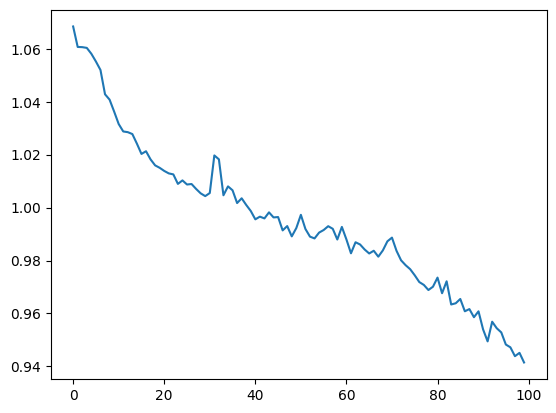

In [17]:
plt.plot(np.arange(0, 100), loss_l)

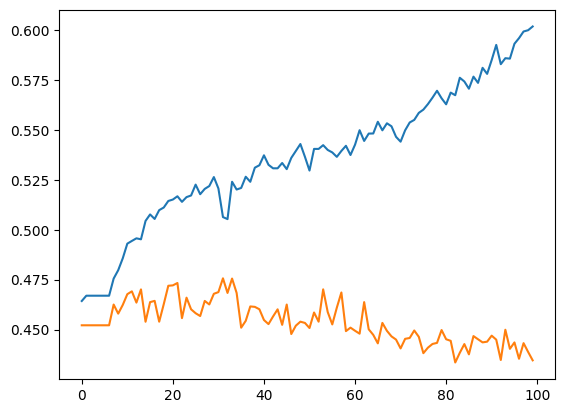

In [16]:
plt.plot(np.arange(0, 100), train_acc_l)
plt.plot(np.arange(0, 100), test_acc_l)